<p>
<h1><b><center>Mecánica de Medios Continuos</center></b></h1>
<h2><b><center>Prof. Jorge I. Zuluaga</center></b></h1>
<h2><b><center>Tarea 1</center></b><h2>
<h3><b><center>Termalización de un gas</center></b><h3>
<h5><center><b>Asignada</b>: 15 de Agosto de 2023</center><h5>
<h5><center><b>Entrega</b>: 31 de Agosto de 2023</center><h5>
</p>

<hr/>
<b>Nombre</b>: Manuela Góez Estepa
<br/>
<b>Cédula</b>: 1000902940
<br/>
<b>Última actualización</b>: 30 Agosto de 2023
<hr/>

## Enunciado

**Objetivo**: El objetivo de esta tarea es simular el proceso de *termalización* de un gas de partículas monoatómicas y poner a prueba algunos de los principios básicos de la mecánica estadística.

**Procedimiento**:

Para conseguir el objetivo:

1. Partiendo del notebook desarrollado en la clase de Mecánica Estadística generar posiciones al azar para N partículas puntuales, en una caja rectangular de lado L.

2. Para las velocidades, asignar inicialmente a todas las partículas velocidades al azar pero con la misma magnitud, p.e. $v_{0}$ = 1 (en unidades termodinámicas).

3. Definir un paso de tiempo para realizar la simulación del movimiento de las partículas así:

   - Calcular $L_{mol}$ en la caja.
   - El paso de tiempo será $dt = (L_{mol}/v_0)/f_t$ donde $f_t = 10$. Puede hacer más pequeño o más grande $f_t$ de dependiendo de si la simulación tarda mucho tiempo en ejecutarse.

4. Simular el movimiento de las partículas del gas así:

   - Por cada paso de tiempo modificar la posición de las partículas con la velocidad que cada una tenga en un momento dado.

   - Si una partícula se sale por un lado de la caja la partícula debe volver a la caja por el lado opuesto (condiciones de frontera periódicas).

   - En cada paso de tiempo, y por cada partícula, determinar cuál de las demás partículas de la caja esta más cerca. Si la distancia a la que se encuentra la otra partícula es menor que $L_{mol}/f_d$, donde $f_d=10$ asumiremos que las dos partículas chocan y calcularemos el resultado del choque elástico entre ellas. Puede modificar el parámetro $f_d$ de acuerdo a los resultados.

5. Haga un histograma de la rapidez de las partículas cada 100 pasos de tiempo y mire como a medida que se producen los choques va cambiando la distribución de velocidades.

6. Cuando la distribución de velocidades tenga la apariencia de una distribución de Maxwell-Boltzmann, decimos que la simulación o el gas, ha termalizado. Determine la temperatura y la presión del gas usando las leyes que encontramos en clase. La presión no tiene que calcularse usando choques, puede usarse la relación que tiene con la densidad de energía cinética.

**Resultados esperados**:

- Este notebook con el procedimiento debidamente comentado.

- Gráficos mínimos:
  - Varios gráficos con distribución de la rapidez de las partículas durante la simulación.

- Datos mínimos:
  - Valor de la temperatura al final de la simulación.
  - Valor de la presión al final de la simulación.

- Gráficos opcionales:
  - Animación del movimiento de las partículas del gas.
  - Evolución de la temperatura como función del tiempo.
  - Evolución de la presión como función del tiempo.

- En caso de utilizar ayudas como `ChatGPT` o códigos de `Stack Over Flow` debe citar debidamente la fuente, pero también entender a cabalidad el código, el profesor puede pedir justificación.

# Solución

In [ ]:
#@markdown Librerías
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style
from sklearn.preprocessing import normalize
!pip install -q celluloid
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera

## 1 y 2. Creando las partículas: Posiciones y velocidades.

### Especificaciones del gas y la caja

In [ ]:
#Por facilidad, asignemos la dimensión del lado del cubo como L=100

L=10       #@param {type:'number'}
N=1000    #@param {type:'number'}
v0=1       #magnitud de la velocidad

### Unidades Termodinámicas

Inicialmente, debemos aclarar que la siguiente simulación de la termalización de un gas se realizará usando las unidades termodinámicas, en las que la constante de Boltzmann se escoje igual a 1.



$$
k_B =  1.380649\times 10^{-23} \frac{\mathrm{kg\;m^2}}{\mathrm{K\;s^2}}= 1
$$
Usando la ecuación que relaciona las unidades termodinámicas con la constante de Boltzmann:

$$
k_B = \frac{U_M U_L^2}{U_T U_t^2}
$$

Arbitariamente se escogen las unidades termodinámicas para masa, longitud y temperatura, posteriormente se determina la unidad temporal.

In [ ]:
#@markdown Tomando de referencia el notebook de clase.

kB = 1.380649e-23 # kg m^2 / (K s^2)
UM = 1.672621e-27 # kg                         Masa del protón
UL = 1e-9 # m
UT = 300 # K                                   Temperatura ambiente

Ut = np.sqrt(UM*UL**2/(UT*kB))

KB = 1

print(f"""
_______________________________________________
Las unidades termodinámicas a trabajar tendrán
las siguientes equivalencias:

    Uₘ       = {UM:.3g} [kg]
    Uₗ       = {UL:.3g} [m]
    Uₜₑₘₚ    = {UT:.3g} [K]
    Uₜ       = {Ut:.3g} [s]

_______________________________________________
""")



_______________________________________________
Las unidades termodinámicas a trabajar tendrán
las siguientes equivalencias:

    Uₘ       = 1.67e-27 [kg]
    Uₗ       = 1e-09 [m]
    Uₜₑₘₚ    = 300 [K]
    Uₜ       = 6.35e-13 [s]

_______________________________________________



### Creación de Partículas

En este punto es clave tener presente que  se quieren generar partículas del gas distribuidas uniformemente dentro de la caja, donde además, éstas tengan velocidades aleatorias con distribución uniforme.

Para ello, se puede pensar que estos vectores corresponden a puntos aleatorios generados sobre una esfera de radio $V_0$ donde en este caso $V_0=1$. En cuya situación no basta con crear números con distribución uniforme en un rango, lo que equivaldría a puntos uniformes en una recta, sino que al trabajar con un segmento curvo se debe ser más cuidadoso en la forma en que se distribuirán esos puntos.

Con base en https://www.bogotobogo.com/Algorithms/uniform_distribution_sphere.php se generan los vectores a partir de un ángulo polar y otro azimutal tal que:

\begin{align}
\theta&=2\pi u \\
\phi&=arccos(2v-1)
\end{align}

donde $u,v$ son números aleatorios que subtiendes a una distribución de probabilidad uniforme, tal que $u,v \sim U[0,1]$.

Luego, las coordenadas cartesianas de los vectores se obtienen de la transformación:

\begin{align}
x &= cos(\theta)sin(\phi)\\
y &= sin(\theta)sin(\phi)\\
z &= cos(\phi)
\end{align}



In [ ]:
#@markdown Creemos una clase llamada *particulas* que tienen posición, velocidad, energía cinética y momento.

class Particulas:  #Recibe N de partículas y la masa de ellas

  def __init__(self,N):
    self.N=N
    self.pos=np.random.uniform(0,L,(self.N,3))          #Se crea dentro del init para no cambiar la matriz cada que se corra el atributo de posición
    self.u=np.random.uniform(0,1,(self.N,1))            #se crean los numeros aleatorios auxiliares
    self.v=np.random.uniform(0,1,(self.N,1))

  def posiciones(self):
    return self.pos

  def velocidades(self):
    theta = 2 * np.pi * self.u
    phi = np.arccos(2 * self.v - 1)

    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)

    vel = np.hstack((x,y,z))                            # Queda un arreglo de velocidades de dimensión (N,3)

    return vel

  def grafica(self,pos1,vel1, titulo = "Partículas de gas ideal"):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.set_title(titulo)
    ax1.scatter(pos1[:,0], pos1[:,1], pos1[:,2], c='crimson', marker='o', label="Partículas", s= 0.5)
    ax1.quiver(pos1[:,0], pos1[:,1], pos1[:,2],vel1[:,0], vel1[:,1], vel1[:,2],color="gray",alpha=0.1, label="Velocidad")
    ax1.set_xlabel("$x$");ax1.set_ylabel("$y$");ax1.set_zlabel("$z$")
    plt.legend()
    #plt.show()

  def avanzar_dt(self,r,v,dt):                          # Se ingresa como argumento la posicion y velocidad porque estas van cambiando en la simulacion.
    return r+v*dt

  def colision(self,pos1,pos2,vel1,vel2):               # pos1 y vel1 corresponden a la primera partícula, analogo a la segunda.

    vel_despues1 = vel1 - np.dot((vel1-vel2),(pos1-pos2)) * (pos1 - pos2) / (np.linalg.norm(pos1-pos2)**2)
    vel_despues2 = vel2 - np.dot((vel2-vel1),(pos2-pos1)) * (pos2 - pos1) / (np.linalg.norm(pos2-pos1)**2)

    return vel_despues1, vel_despues2

  def cinetica(self,mag_velocidades): #Array de dimensiones (N,1)
    return 1/2*mag_velocidades**2


In [ ]:
#@markdown Creamos un primer conjunto de N partículas.

part1 = Particulas(N)
pos1 = part1.posiciones()
vel1 = part1.velocidades()

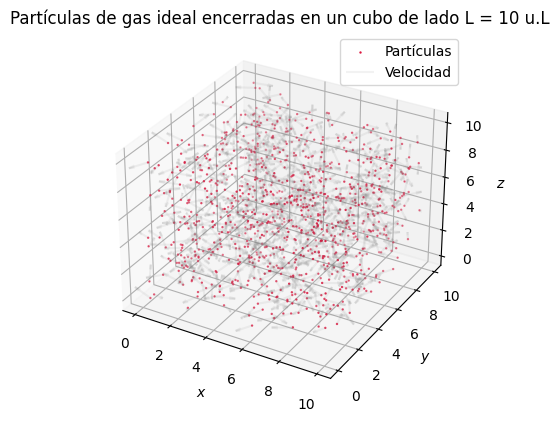

In [ ]:
#@markdown Creamos la figura para ver que se estén creando correctamente las partículas

part1.grafica(pos1,vel1,titulo=f"Partículas de gas ideal encerradas en un cubo de lado L = {L} u.L")

## 3. Determinando el paso de tiempo.

### Calculo de $L_{mol}$

Consideremos que para calcular la escala de longitud molar:

$$L_{mol}=\left(\ \frac{M_{mol}}{\rho N_A} \right)^{1/3}$$

Para calcular la densidad, usamos la densidad de número teórica, en donde al estar las partículas distribuidas uniformemente sobre la caja, entonces:

$$\rho=\frac{N}{V}$$

In [ ]:
#@markdown Se halla la densidad teórica

rho = N / L**3

Otro factor a tener en cuenta es el valor de $M_{mol}$, para esto cabe recordar que ello corresponde a la masa molar y es útil para determinar la cantidad de masa en una sustancia. Explícitamente:

$$M_{mol}=m_{A}N_A$$

donde $N_A=6.022 \times 10^{23} \ \mbox{partículas/mol}$ es el número de Avogadro,$m_A$ es la masa atómica pero que en este caso, suponemos como $m_A = 1 \ [U_M]$, es decir, cada partícula simulada se puede considerar como un átomo de Hidrógeno, puesto que la masa atómica sería la del protón y se desprecia el aporte del electrón.

De modo que:
$$L_{mol}=\left(\ \frac{M_{mol}}{\rho N_A} \right)^{1/3}=\left(\ \frac{m_A}{\rho} \right)^{1/3}$$

In [ ]:
#@markdown Se calcula la longitud molar

m_A=1          #U_M

Lmol=(m_A/rho)**(1/3)

print(f"""
_______________________________________________
La Longitud molar o distancia media entre
partículas es:

      Lₘₒₗ = {Lmol:.3g} Uₗ
_______________________________________________
""")


_______________________________________________
La Longitud molar o distancia media entre
partículas es:

      Lₘₒₗ = 1 Uₗ
_______________________________________________



In [ ]:
#@markdown El paso del tiempo será $d_t=(L_{mol}/v_0)/f_t$ con $f_t=10$

ft = 10
dt = Lmol/v0/ft

print(rf"""
_______________________________________________
Se determina que el paso de tiempo será:

      $d_t$ = {dt:.3g} $U_t$
_______________________________________________
""")


_______________________________________________
Se determina que el paso de tiempo será:

      $d_t$ = 0.1 $U_t$
_______________________________________________



### Anexo: Exploración de densidad de partículas mediante volumen de control.

En esta exploración se opta por definir un volumen de control y midiendo la densidad de masa a partir del número de partículas encerradas. Sin embargo, esta aproximación se puede hacer cuando se tienen muchas partículas, por lo tanto se genera un nuevo grupo de partículas para evaluar la similitud entre la densidad de partículas teórica y la obtenida numéricamente.

In [ ]:
#@markdown Creamos un conjunto de N partículas de prueba
N_prueba=10000    #@param {type:'number'}


part_prueba = Particulas(N_prueba)
pos_prueba = part_prueba.posiciones()
vel_prueba = part_prueba.velocidades()

In [ ]:
#@markdown Supongamos que el volumen de control va a ser 1/10 de L

dL=L/10
dV=dL**3

P=np.random.uniform(0,L,3)   #Creamos un punto aleatorio en la caja con coordenadas (x,y,z)

#Usamos el código del ejemplo para encontrar las partículas en el volumen de control
n=np.where((abs(pos_prueba[:,0]-P[0])<=dL/2)&(abs(pos_prueba[:,1]-P[1])<=dL/2)&(abs(pos_prueba[:,2]-P[2])<=dL/2))[0]

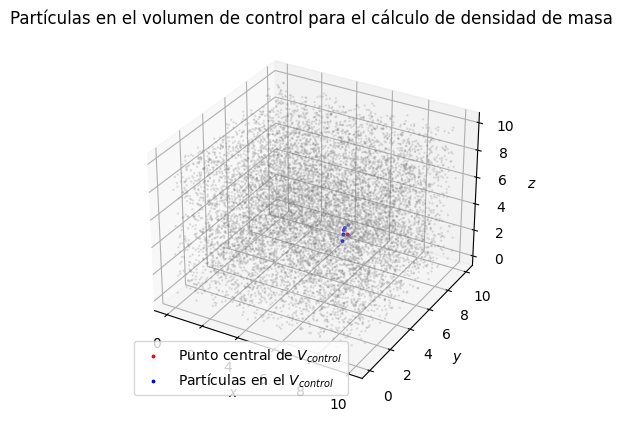

In [ ]:
#@markdown Ilustración de la escogencia en el volumen de control
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title(f"Partículas en el volumen de control para el cálculo de densidad de masa")
ax1.scatter(pos_prueba[:,0], pos_prueba[:,1], pos_prueba[:,2], c='gray', marker='o',alpha=0.2, s=0.5)
ax1.scatter(P[0],P[1],P[2],color="red", label=r"Punto central de $V_{control}$", s=3)
ax1.set_xlabel("$x$");ax1.set_ylabel("$y$");ax1.set_zlabel("$z$")
ax1.scatter(pos_prueba[n,0], pos_prueba[n,1], pos_prueba[n,2],color="blue",label=r"Partículas en el $V_{control}$", s=3)
plt.legend(loc="lower left")
plt.show()

Note que las partícula que están en el volumen de control nos proporcionan un único valor de densidad, en este caso es apropiado utilizar diversos volumenes de control y definir el valor de densidad como un promedio de ellos. Se espera que éste valor sea parecido a la densidad teórica.

No obstante, cabe mencionar que no se está solicitando la densidad de número, sino que para obtener $L_{mol}$ es necesario tener la densidad de masa, para lo cual se asumen particulas puntuales de masa $U_M$.

In [ ]:
#@markdown Densidad de masa es $\rho=N_{control} U_M/V_{control}$. A continuación se puede escoger arbitrariamente el valor de volúmenes de control para calcular la densidad de masa promedio, tenga en cuenta que entre mayor sea este número, mejor será la aproximación.

N_Volumenes_control=1000       #@param {type:'number'}

rhos = 0

for i in range(N_Volumenes_control):
  P=np.random.uniform(0,L,3)
  n=np.where((abs(pos1[:,0]-P[0])<=dL/2)&(abs(pos1[:,1]-P[1])<=dL/2)&(abs(pos1[:,2]-P[2])<=dL/2))[0]
  rhos += len(n)/dV           #U_M/U_L**3  no se multiplica por U_M pues cada partícula pesa 1U_M

rho_mean = rhos/N_Volumenes_control

print(f"""
_______________________________________________
La densidad de masa promedio calculada en las
unidades termodinámicas es:

    ρ = {rho_mean:.3g} [Uₘ / Uₗ³]

Y suponiendo una distribución homogénea del gas,
la densidad de masa teórica es:

    ρₜ = {N/L**3:.3g} [Uₘ / Uₗ³]

donde 1 Uᵨ = {UM/UL**3:.3g} [kg/m³]
_______________________________________________
""")


_______________________________________________
La densidad de masa promedio calculada en las
unidades termodinámicas es:

    ρ = 0.922 [Uₘ / Uₗ³]

Y suponiendo una distribución homogénea del gas,
la densidad de masa teórica es:

    ρₜ = 1 [Uₘ / Uₗ³]

donde 1 Uᵨ = 1.67 [kg/m³]
_______________________________________________



## 4. Simulación

### Avanzar la posición de las partículas

De la cinemática y considerando un movimiento rectilíneo uniforme, se tiene que la posición es $\vec{r}=\vec{r}_0+\vec{v}t$. Se calcula las nuevas posiciones para las $N$ partículas.

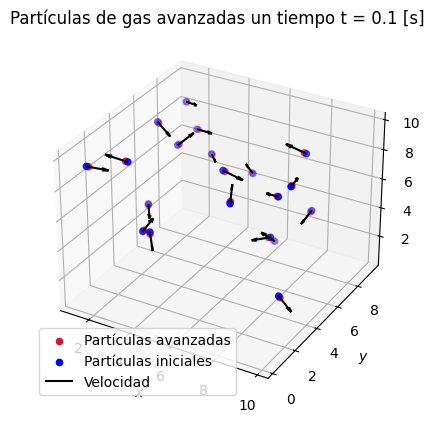

In [ ]:
# Avanzando posición desde la clase
posicion_avanzada = part1.avanzar_dt(pos1,vel1,dt)

#@markdown Para ilustrar que se está avanzando correctamente las posiciones solo se mostrarán las primeras N_grafica partículas avanzadas un tiempo dt.
N_graf = 20    #@param {type:'number'}

#@markdown No obstante, note que todas las partículas se están avanzando en el tiempo, no solo N_grafica.

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title(f"Partículas de gas avanzadas un tiempo t = {dt:.3g} [s]")
ax1.scatter(posicion_avanzada[:N_graf,0], posicion_avanzada[:N_graf,1], posicion_avanzada[:N_graf,2], c='crimson', marker='o', label="Partículas avanzadas")
ax1.scatter(pos1[:N_graf,0], pos1[:N_graf,1], pos1[:N_graf,2], c='blue', marker='o', label="Partículas iniciales")
ax1.quiver(pos1[:N_graf,0], pos1[:N_graf,1], pos1[:N_graf,2],vel1[:N_graf,0], vel1[:N_graf,1], vel1[:N_graf,2],color="black",alpha=1, label="Velocidad")
ax1.set_xlabel("$x$");ax1.set_ylabel("$y$");ax1.set_zlabel("$z$")
plt.legend(loc="lower left")
plt.show()

### Simulación con condiciones de frontera y choques

Para analizar el choque entre las partículas, es necesario determinar aquellas que están más cerca y con las cuales puede colisionar. Se podría hacer "a fuerza bruta" calculando directamente la distancia entre todas las partículas, sin embargo, esto no es computacionalmente eficiente debido a que para muchas partículas implicaría comprobar la distancia para cada una con las demás.

Para obtener la velocidad después de una colisión entre dos partículas en 3D se usan las ecuaciones de https://en.wikipedia.org/wiki/Elastic_collision:

\begin{align}
v_1'&= \vec{v_1} - \frac{\langle \vec{v_1} -\vec{v_2},\vec{x_1}-\vec{x_2}\rangle}{|\vec{x_1}-\vec{x_2}|^2}(\vec{x_1}-\vec{x_2}) \\
v_2'&= \vec{v_2} - \frac{\langle \vec{v_2} -\vec{v_1},\vec{x_2}-\vec{x_1}\rangle}{|\vec{x_2}-\vec{x_1}|^2}(\vec{x_2}-\vec{x_1})
\end{align}

In [ ]:
#@markdown Se crea la simulación usando un número establecido de frames y escogiendo el número de partículas en ella (para apreciar el movimiento de las partículas individuales). En ésta ya se implementan todas las condiciones, incluyendo la frontera y el choque entre ellas.
fd = 5

%matplotlib inline

fig , ax1 = plt.subplots(figsize=(5,5),facecolor="whitesmoke")

#Configuración inicial de la gráfica
ax1.set_title(f"Partículas de gas")
ax1.set_xlabel("$x$");ax1.set_ylabel("$y$")


camera = Camera(fig)


#Creando frames individuales
frames = 100      #@param {type:'number'}
N_graf = 20      #@param {type:'number'}
#N_graf = N


#Partiendo de la posición inicial
posicion_avanzada = np.copy(pos1)
vel_despues = np.copy(vel1)


for frame in range(frames):

  #Condición de choque elástico
  vel_despues1 = np.copy(vel_despues)

  for i in range(N_graf):
    for j in range(N_graf):
      if i!=j:
        distancia = np.linalg.norm(posicion_avanzada[i]-posicion_avanzada[j])
        if distancia <= Lmol/fd:

          vel_despues1[i],vel_despues1[j] = part1.colision(posicion_avanzada[i],posicion_avanzada[j],vel_despues[i],vel_despues[j])

  #Para indicar que en el siguiente marco tome la ultima velocidad
  vel_despues = np.copy(vel_despues1)


  #avanza la posición
  posicion_avanzada = part1.avanzar_dt(posicion_avanzada[:N_graf],vel_despues1[:N_graf],dt)

  #Condición de frontera periodica
  for particula in range(N_graf):
    for coord in range(3): #las coordenadas son x=0,y=1,z=2

    #se comprueba si alguna de las coordenadas de cada partícula está por fuera y se agrega la condición periodica
      if (posicion_avanzada[particula,coord]>=L) or (posicion_avanzada[particula,coord]<=0):

        #note que el signo menos hace que se aplique tanto si sale por la izquierda o la derecha de la frontera
        posicion_avanzada[particula,coord] = L - posicion_avanzada[particula,coord]

  #grafica las partículas
  ax1.scatter(posicion_avanzada[:,0], posicion_avanzada[:,1], c='crimson', marker='o')

  # Captura del Frame
  camera.snap()


plt.close()

In [ ]:
#@markdown Presentando la simulación como video embebido, se hace en dos dimensiones puesto que en 3D se generan problemas.
# Create animation
anim = camera.animate(interval = 50, repeat = True, repeat_delay = 500)

# Inline display
HTML(anim.to_html5_video())

## 5. Distribución de velocidades

In [ ]:
#@markdown En este caso, frames corresponde también al número de pasos de tiempo

fig , ax1 = plt.subplots(figsize=(5,5),facecolor="whitesmoke")

#Configuración inicial de la gráfica
ax1.set_title(f"Histograma")
ax1.set_xlabel("Rapidez");ax1.set_ylabel("Frecuencia")


camera = Camera(fig)


#Creando frames individuales
frames = 400      #@param {type:'number'}


#Partiendo de la posición inicial
pos2 = np.copy(pos1)
vel2 = np.copy(vel1)


for frame in range(frames):

  rapidez = np.linalg.norm(vel2,axis=1)
  ax1.hist(rapidez,color = "lightcoral")


  vel3 = np.copy(vel2)

  #Colision

  for i in range(N):
    for j in range(N):
      if i != j :
        if np.linalg.norm(pos2[i]-pos2[j]) <= Lmol/fd:
          vel3[i],vel3[j] = part1.colision(pos2[i],pos2[j],vel2[i],vel2[j])

  vel2 = np.copy(vel3)

  pos2 = part1.avanzar_dt(pos2,vel2,dt)

  #Condición de frontera periodica

  for particula in range(N):
    for coord in range(3):
      if (pos2[particula,coord]>=L) or (pos2[particula,coord]<=0):
        pos2[particula,coord] = L - pos2[particula,coord]


  # Captura del Frame
  camera.snap()


plt.close()

In [ ]:
#@markdown Cambio en la distribución de rapidez de las partículas

# Create animation
anim = camera.animate(interval = 50, repeat = True, repeat_delay = 500)

# Inline display
HTML(anim.to_html5_video())

### Distribución de Maxwell Boltzmann

(array([  9.,  10.,  42.,  62.,  52.,  84.,  92., 108., 113., 107.,  74.,
         73.,  54.,  48.,  32.,  19.,   9.,   8.,   2.,   0.,   0.,   2.]),
 array([0.11407093, 0.21156367, 0.3090564 , 0.40654914, 0.50404187,
        0.60153461, 0.69902734, 0.79652008, 0.89401281, 0.99150555,
        1.08899828, 1.18649102, 1.28398375, 1.38147648, 1.47896922,
        1.57646195, 1.67395469, 1.77144742, 1.86894016, 1.96643289,
        2.06392563, 2.16141836, 2.2589111 ]),
 <BarContainer object of 22 artists>)

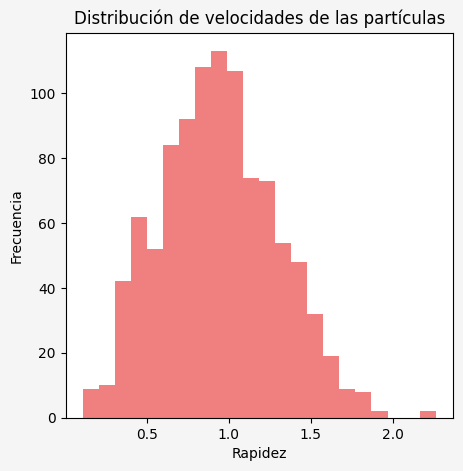

In [ ]:
#@markdown Distribución de velocidades para el último paso

fig , ax1 = plt.subplots(figsize=(5,5),facecolor="whitesmoke")
ax1.set_title(f"Distribución de velocidades de las partículas")
ax1.set_xlabel("Rapidez");ax1.set_ylabel("Frecuencia")
ax1.hist(rapidez,color="lightcoral", bins="auto")

## 6. Temperatura y Presión

### Temperatura

Para calcular la Temperatura y la Presión en el gas, se puede usar sus respectivas relaciones con la energía cinética promedio de las partículas.

Del teorema de la equipartición de la energía para partículas con tres grados de libertad, tenemos que:

\begin{equation}
<E_k>=\frac{3}{2} k_BT
\end{equation}

Por lo que:

\begin{equation}
T=\frac{2<E_k>}{3k_B}
\end{equation}

Donde se puede obtener la energía cinética promedio como:

\begin{equation}
<E_k>=<\frac{1}{2}m_Av^2>
\end{equation}


In [ ]:
#@markdown Calculando el promedio de la energía cinética

k_prom=np.mean(part1.cinetica(rapidez))

print(f"""
_______________________________________________
La energía cinética promedio de las partículas
es:

      Eₖ = {k_prom:.3g} Uₖ

En donde una unidad termodinámica de Energía es:

      Uₖ = {UM*UL**2/Ut**2:.3g} [kg m²/s²]
_______________________________________________
""")


_______________________________________________
La energía cinética promedio de las partículas
es:

      Eₖ = 0.506 Uₖ

En donde una unidad termodinámica de Energía es:

      Uₖ = 4.14e-21 [kg m²/s²]
_______________________________________________



In [ ]:
#@markdown Se obtiene el valor de la temperatura recordando que la constante de Boltzmann equivale a 1.


T=2/3*k_prom

print(f"""
_______________________________________________
La Temperatura del gas es

      T = {T:.3g} Uₜₑₘₚ
_______________________________________________
""")



_______________________________________________
La Temperatura del gas es

      T = 0.337 Uₜₑₘₚ
_______________________________________________



### Presión

Por otra parte, también se tiene que en un gas, la presión está relacionada con la energía cinética como:

$$P=\frac{2}{3}n<E_k>$$

donde $n$ es densidad de número.

In [ ]:
#@markdown Cálculo de Presión

Pres = 2/3 * rho * k_prom

print(f"""
_______________________________________________
La Presión del gas es:

      P = {Pres:.3g} Uₚᵣₑₛᵢₒₙ

Donde una unidad de presión termodinámica es:

      Uₚᵣₑₛᵢₒₙ = {UM*UL/Ut**2:.3g} [kg m / s²]
_______________________________________________
""")


_______________________________________________
La Presión del gas es:

      P = 0.337 Uₚᵣₑₛᵢₒₙ

Donde una unidad de presión termodinámica es:

      Uₚᵣₑₛᵢₒₙ = 4.14e-12 [kg m / s²]
_______________________________________________



### Anexo: Comparación entre la termalización del gas y la distribución de Maxwell Boltzmann

Veamos que la distribución de Maxwell-Boltzmann se define como una función que depende de la velocidad de las partículas, tal que:

\begin{equation}
f(v)=4\pi(\frac{m}{2\pi k_BT})^{3/2}v^2e^{-\frac{mv^2}{2k_BT}}
\end{equation}

donde $k_B$ es la constante de Boltzmann y T es la temperatura absoluta.

La distribución del histograma se puede aproximar como:

\begin{equation}
h(v_i)=N \int v_i^{v_i+1} p(v) dv \approx N p(v_i) \triangle v_i
\end{equation}

en donde $p(v_i)$ es la distribución teórica y $\triangle v_i$ el ancho de los bins.

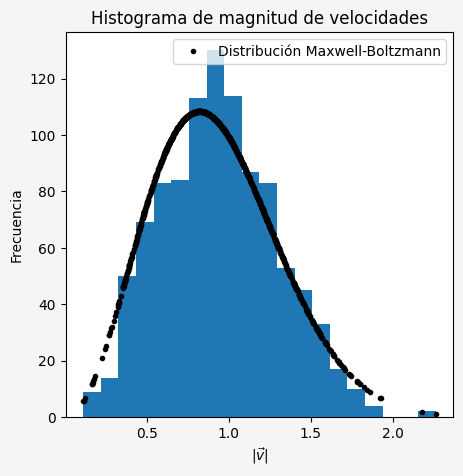

In [ ]:
#@markdown Histograma

bins=20     #@param {type:'number'}

#Los datos del histograma se obtienen de np.histogram pero se grafica con plt.hist
frec,lista=np.histogram(rapidez,bins=bins)
delta_v=lista[1]-lista[0] #Para encontrar el ancho de los  bins

#distribución teórica
f_v=4*np.pi*(1/(2*np.pi*T))**(3/2)*rapidez**2*np.exp(-rapidez**2/(2*T))

#Figura
plt.figure(figsize=(5,5), facecolor = "whitesmoke")
plt.title("Histograma de magnitud de velocidades")
plt.plot(rapidez,N*f_v*delta_v,".",color="k",label="Distribución Maxwell-Boltzmann")
plt.hist(rapidez,bins=bins)
plt.xlabel(r"|$\vec{v}$|")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()